In [240]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from pandas import DataFrame 

#ScikitLearn Library 
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Regex Library
import re
import string


In [164]:
#Loading the Dataset
df = pd.read_csv("Clothing_&_Accessories.csv")

In [165]:
#Exploratory Analysis
print(df.columns)
print(df.shape)
len(df['userId'].unique())

Index(['productId', 'title', 'profileName', 'score', 'purchasedate', 'summary',
       'userId', 'Class'],
      dtype='object')
(351523, 8)


69697

In [166]:
#compute the count and mean value as group by the products
count = df.groupby("productId", as_index=False).count()
mean = df.groupby("productId", as_index=False).mean()

In [167]:
#merge two dataset create merge
merge = pd.merge(df, count, how='right', on=['productId'])
merge.head()

,productId,title_x,profileName_x,score_x,purchasedate_x,summary_x,userId_x,Class_x,title_y,profileName_y,score_y,purchasedate_y,summary_y,userId_y,Class_y
0,B000F8L3IK,Mcarthur San Diego Chargers Bath Robe,Eric Newhart,4.0,2013-01-20,"High quality, but very large.",A2PF4C1R6OALE9,Clothing_&_Accessories,1,1,1,1,1,1,1
1,B0002ZI3NY,Amazon.com,yumiwong,5.0,2012-09-27,Excellent purchase,A3M0FD65RC3DJ7,Clothing_&_Accessories,1,1,1,1,1,1,1
2,B0009Q5XOS,"adidas Men's 3-Stripe Fleece Pant,Black/White...",J. Williams,4.0,2011-01-09,"comfy,warm.. but run big",A1UIXA657W8LWT,Clothing_&_Accessories,1,1,1,1,1,1,1
3,B00028NJTY,Amazon.com,MICIA HARDAWAY,5.0,2012-12-06,Great fit!,A3RNIF23UKNKKB,Clothing_&_Accessories,3,3,3,3,3,3,3
4,B00028NJTY,Amazon.com,Lisa,2.0,2012-12-14,Too Uncomfortable and Too Big,A38DKLX0UNTAL9,Clothing_&_Accessories,3,3,3,3,3,3,3


In [168]:
#rename columns
merge["Count"] = merge["userId_y"]
merge["score"] = merge["score_x"]
merge["summary"] = merge["summary_x"]

In [169]:
#Create New datafram with selected variables
merge = merge[['productId','summary','score',"Count"]]
merge.head()

,productId,summary,score,Count
0,B000F8L3IK,"High quality, but very large.",4.0,1
1,B0002ZI3NY,Excellent purchase,5.0,1
2,B0009Q5XOS,"comfy,warm.. but run big",4.0,1
3,B00028NJTY,Great fit!,5.0,3
4,B00028NJTY,Too Uncomfortable and Too Big,2.0,3


In [170]:
#choose only products have over 100 reviews
merge = merge.sort_values(by = 'Count')
df2 = merge[merge.Count >= 100]
df2.head()

,productId,summary,score,Count
217956,B000HAQ69C,Comfortable,4.0,100
114187,B00004U1J2,Show stopper!,5.0,100
114176,B00004U1J2,Pleasantly surprised!,5.0,100
114177,B00004U1J2,Buzz lightyear wings,5.0,100
114178,B00004U1J2,Completed my sons costume!,5.0,100


In [171]:
#create new dataframe as combining all summary with same product Id
df4 = df.groupby("productId", as_index=False).mean()
productID_summary = df2.groupby("productId")["summary"].apply(list)

In [172]:
#Converting into a new dataset
productID_summary = pd.DataFrame(productID_summary)
productID_summary.to_csv("productID_summary.csv")

In [173]:
df3 = pd.read_csv("productID_summary.csv")

In [174]:
df3 = pd.merge(df3, df4, on="productId", how='inner')
df3 = df3[['productId','summary','score']]

In [175]:
#https://stackoverflow.com/questions/5843518/remove-all-special-characters-punctuation-and-spaces-from-string/5843547#5843547
cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

In [176]:
df3["summary_clean"] = df3["summary"].apply(cleanup)
df3 = df3.drop_duplicates(['score'], keep='last')
df3 = df3.reset_index()
df3.head()

,index,productId,summary,score,summary_clean
0,1,B0000224GM,"[' Once again Carhartt fits the big guy', ' Ve...",4.745455,once again carhartt fits the big guy very comf...
1,2,B00004U1J2,"[' Show stopper!', ' Pleasantly surprised!', '...",3.760000,show stopper pleasantly surprised buzz lightye...
2,19,B0000868IV,"[' AWESOME service and product!!', ' small cup...",4.235294,awesome service and product small cup excellen...
3,30,B00008ION9,"[' Poor support', ' Bali cotton bra', ' Janeth...",4.096154,poor support bali cotton bra janeth best deser...
4,44,B00008IOOF,"[' Bra Perfection', ' Bali Double Support Cott...",4.087379,bra perfection bali double support cotton stre...


In [183]:
#Converting into a vector form
keywords = df3["summary_clean"] 
vect = CountVectorizer(max_features = 100, stop_words='english') 
X = vect.fit_transform(keywords) 

In [184]:
df5 = DataFrame(X.A, columns=vect.get_feature_names())
df5 = df5.astype(int)
df5

,amazing,amazon,awesome,backpack,bad,bag,best,better,big,bit,...,time,value,ve,vest,wanted,warm,wear,work,wrangler,wrong
0,1,0,4,0,1,0,4,1,2,0,...,0,0,0,0,0,0,4,1,0,0
1,0,0,1,0,0,0,2,1,1,0,...,0,1,0,0,0,0,0,1,0,0
2,1,0,3,0,0,0,9,1,0,1,...,0,1,0,0,0,0,0,0,0,2
3,0,0,0,0,1,0,3,0,0,1,...,0,0,2,0,1,0,1,0,0,0
4,0,0,0,0,1,0,3,0,0,1,...,0,0,2,0,1,0,1,0,0,0
5,0,0,0,0,1,0,3,0,0,1,...,0,0,2,0,1,0,1,0,0,0
6,6,0,0,0,0,0,18,0,1,1,...,2,0,2,0,0,0,2,0,0,1
7,0,0,0,0,0,0,4,0,3,1,...,0,0,0,0,2,0,4,3,16,1
8,0,0,0,0,0,0,4,0,3,1,...,0,0,0,0,2,0,4,3,16,1
9,0,0,0,0,0,0,4,0,3,1,...,0,0,0,0,2,0,4,3,16,1


In [185]:
df5.to_csv("productId_vectorized.csv")

In [186]:
#https://stackoverflow.com/questions/3674409/how-to-split-partition-a-dataset-into-training-and-test-datasets-for-e-g-cros
# First let's create a dataset called X
X = np.array(df5)
# create train and testing dataset
tpercent = 0.8
tsize = int(np.floor(tpercent * len(df5)))
df5_train = X[:tsize]
df5_test = X[tsize:]
#len of train and test
lentrain = len(df5_train)
lentest = len(df5_test)

In [187]:
lentest

38

In [188]:
# Using KNN algorithm to find the neighbours. Then we will fit it to dataset X.
neighbours = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(df5_train)

#Distance betwwen each datapoints using Euclidean Method
distances, indices = neighbours.kneighbors(df5_train)

In [189]:
#find most related products - This is for the total number in test data
for i in range(lentest):
    a = neighbours.kneighbors([df5_test[i]])
    related_product_list = a[1]
    
    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("For product :", df3["productId"][lentrain + i] ,", the average Score is :",df3["score"][lentrain + i])
    print ("The 1st Similar product is ", df3["productId"][first_related_product] ," , the average Score is :",df3["score"][first_related_product])
    print ("The 2nd Similar product is ", df3["productId"][second_related_product] ," , the average Score is : ",df3["score"][second_related_product])
    print ("-----------------------------------------------------------")

For product :  B000JHCYTE , the average Score is : 4.747747747747748
The 1st Similar product is   B0000224GM  , the average Score is : 4.745454545454545
The 2nd Similar product is   B0001YS61K  , the average Score is :  4.752212389380531
-----------------------------------------------------------
For product :  B000JIKN0A , the average Score is : 3.312820512820513
The 1st Similar product is   B00008ION9  , the average Score is : 4.096153846153846
The 2nd Similar product is   B00008IOOI  , the average Score is :  4.104761904761904
-----------------------------------------------------------
For product :  B000JLHRII , the average Score is : 3.8088642659279777
The 1st Similar product is   B000FS67LS  , the average Score is : 3.9595238095238097
The 2nd Similar product is   B00016QPAW  , the average Score is :  4.285067873303167
-----------------------------------------------------------
For product :  B000JUGSO8 , the average Score is : 4.477079796264856
The 1st Similar product is   B000IM

# Predicting Review Score


In [190]:
#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
df5_train_target = df3["score"][:lentrain]
df5_test_target = df3["score"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(df5_train, df5_train_target)
knnpreds_test = knnclf.predict(df5_test)
print (knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy Score :",accuracy_score(df5_test_target, knnpreds_test))

[4 4 4 4 4 4 3 4 4 3 3 3 4 4 4 4 4 4 4 4 4 4 4 3 4 4 3 4 4 4 4 4 3 3 4 4 4
 4]
              precision    recall  f1-score   support

           3       0.50      0.44      0.47         9
           4       0.83      0.86      0.85        29

    accuracy                           0.76        38
   macro avg       0.67      0.65      0.66        38
weighted avg       0.75      0.76      0.76        38

Accuracy Score : 0.7631578947368421


In [191]:
#Check which product is from the dataset description
df[df['productId'].str.contains("B000QYEY7U")]

,productId,title,profileName,score,purchasedate,summary,userId,Class
232826,B000QYEY7U,Amazon.com,WrongSKU,2.0,2011-10-01,Sent the wrong one,A1ITCLJXIX3OQD,Clothing_&_Accessories
232827,B000QYEY7U,Amazon.com,Frankie McDougal,2.0,2013-01-28,"Nice Shemagh, bad color",A3HQ0QNMWSMXNO,Clothing_&_Accessories
232828,B000QYEY7U,Amazon.com,Xavier Wolfe,3.0,2012-12-29,Eh...,AMUUMDVUQ4V48,Clothing_&_Accessories
232829,B000QYEY7U,Amazon.com,Teri L. Newman,4.0,2012-12-19,Decent quality Shemagh,A27L5R1M8L38RM,Clothing_&_Accessories
232830,B000QYEY7U,Amazon.com,"Bay33saw ""Person of Fun""",5.0,2012-12-03,Feels and looks great,A3IRGV7L8BV3W5,Clothing_&_Accessories
232831,B000QYEY7U,Amazon.com,DJdoze,5.0,2012-11-30,This is a great alternative if looking for di...,A1U9EV0ZTBIB8H,Clothing_&_Accessories
232832,B000QYEY7U,Amazon.com,Ryan,5.0,2013-02-18,Great,A2T7ENQ1UHYEVL,Clothing_&_Accessories
232833,B000QYEY7U,Amazon.com,Boris,4.0,2013-02-17,Made in India ?!,A13LA82RVQ4OBM,Clothing_&_Accessories
232834,B000QYEY7U,Amazon.com,James M. Gibson,5.0,2013-02-14,Solid,AQH2VUPQLLVQK,Clothing_&_Accessories
232835,B000QYEY7U,Amazon.com,O'Bryan,5.0,2013-02-13,Holy Keffiyeh Batman!,A1U1ZL02KP0Y0K,Clothing_&_Accessories


In [192]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df5_test_target, knnpreds_test)
cm

array([[ 4,  5],
       [ 4, 25]], dtype=int64)

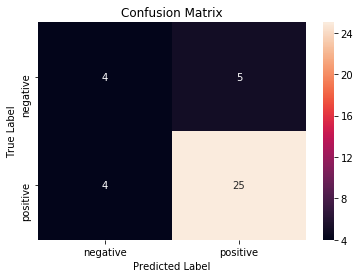

In [194]:
import seaborn as sns
class_label = ["negative","positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Repeating the same method for Customer based filtering


In [241]:
count = df.groupby("userId", as_index=False).count()
mean = df.groupby("userId", as_index=False).mean()

In [242]:
#create new dataframe as combining all summary with same user Id
merge1 = pd.merge(df, count, how='right', on=["userId"])
#rename column
merge1["Count"] = merge1["productId_y"]
merge1["score"] = merge1["score_x"]
merge1["summary"] = merge1["summary_x"]

In [243]:
#Create New datafram with selected variables
merge1 = merge1[["userId",'summary','score',"Count"]]

In [244]:
merge1.head()

,userId,summary,score,Count
0,A2PF4C1R6OALE9,"High quality, but very large.",4.0,1
1,A3M0FD65RC3DJ7,Excellent purchase,5.0,1
2,A1UIXA657W8LWT,"comfy,warm.. but run big",4.0,1
3,A3RNIF23UKNKKB,Great fit!,5.0,21
4,A3RNIF23UKNKKB,Great fit!,5.0,21


In [245]:
#choose only products have over 100 reviews
merge1 = merge1.sort_values(by = 'Count')
df2 = df1[df1.Count >= 100]

In [246]:
df4 = df.groupby("userId", as_index=False).mean()
userId_summary = df2.groupby("userId")["summary"].apply(list)

In [247]:
userId_summary = pd.DataFrame(userId_summary)
userId_summary.to_csv("userId_summary.csv")

In [248]:
df3 = pd.read_csv("userId_summary.csv")
df3 = pd.merge(df3, df4, on="userId", how='inner')
df3 = df3[['userId','summary','score']]

In [249]:
df3["summary_clean"] = df3["summary"].apply(cleanup)


In [250]:
df3 = df3.drop_duplicates(['score'], keep='last')
df3 = df3.reset_index()

In [251]:
docs = df3["summary_clean"] 
vect = CountVectorizer(max_features = 200, stop_words='english') 
X = vect.fit_transform(docs) 
#print(DataFrame(X.A, columns=vect.get_feature_names()).to_string()) 
matrix = DataFrame(X.A, columns=vect.get_feature_names())
matrix = matrix.astype(int)

In [252]:
matrix.to_csv("matrix.csv")
kkk  = df.drop_duplicates(['summary'], keep='last')
kkk = kkk.reset_index()

KNN classifier to find similar user and find their interesting products


In [257]:
#Dataset Preparation
X = np.array(matrix)

tpercent = 0.80
tsize = int(np.floor(tpercent * len(matrix)))
df5_train = X[:tsize]
df5_test = X[tsize:]

lentrain = len(df5_train)
lentest = len(df5_test)

# Fitting the data into the KNN model
neighbors1 = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(df5_train)

# Fiding the distance between the datapoints.
distances, indices = neighbors1.kneighbors(df5_train)

In [258]:
#find similar Customer and similar purchases - Predction Function
for i in range(lentest):
    a = neighbors1.kneighbors([df5_test[i]])
    related_product_list = a[1]
    
    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on  reviews, for Customer ", df3["userId"][lentrain + i])
    print ("The 1st similar Customer is ", df3["userId"][first_related_product], ".") 
    print ("Customer likes following products")
    for i in range(295743):
        if (kkk["userId"][i] == df3["userId"][first_related_product]) & (kkk["score"][i] == 5):
            aaa= kkk["productId"][i]
        
            print (aaa),
print ("--------------------------------------------------------------------")

Based on  reviews, for Customer   AHQ7NDI1L1RP7
The 1st similar Customer is   A3MVS23LU1ZC1E .
Customer likes following products
 B0007YX26S
 B000EE9D00


KeyError: 55324

In [231]:
from sklearn.neighbors import KNeighborsClassifier

In [259]:
df5_train_target = df3["score"][:lentrain]
df5_test_target = df3["score"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors1.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(df5_train, df5_train_target)
knnpreds_test = knnclf.predict(df5_test)
print ("Predicting review score for test dataset customers are : ", knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

AttributeError: 'NearestNeighbors' object has no attribute 'KNeighborsClassifier'

In [221]:
cm = confusion_matrix(df5_test_target, knnpreds_test)
cm

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0]], dtype=int64)

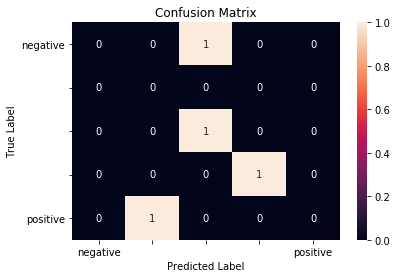

In [223]:
import seaborn as sns
class_label = ["negative"," "," "," ","positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 3. Word correltation based on cluster¶


In [141]:
correlation = df.groupby("score")["summary"].apply(list)


In [142]:
correlation = pd.DataFrame(cluster)
correlation.to_csv("correlation.csv")

In [143]:
correlation1 = pd.read_csv("correlation.csv")

In [148]:
correlation1["Summary_Clean"] = cluster1["summary"].apply(cleanup)


In [144]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS


In [145]:
#https://stackoverflow.com/questions/56553943/how-to-create-word-cloud-of-different-group-in-python
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=400,
        max_font_size=40, 
        scale=3,
        random_state=5 
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

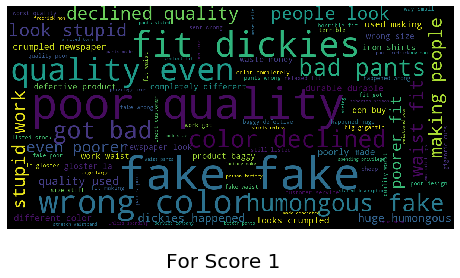

In [149]:
show_wordcloud(correlation1["Summary_Clean"][0], title = "For Score 1")


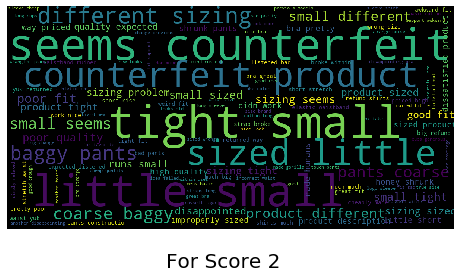

In [150]:
show_wordcloud(correlation1["Summary_Clean"][1] , title = "For Score 2")


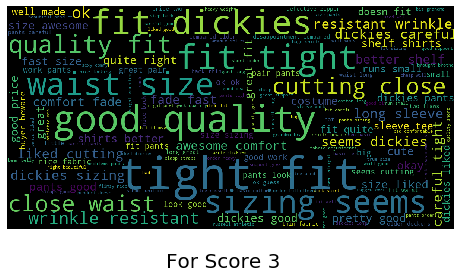

In [151]:
show_wordcloud(correlation1["Summary_Clean"][2], title = "For Score 3")


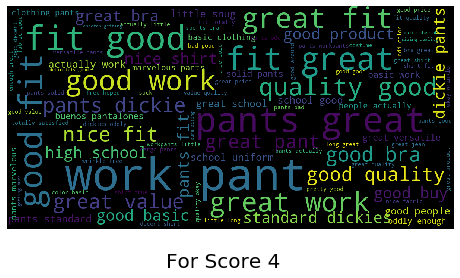

In [152]:
show_wordcloud(correlation1["Summary_Clean"][3], title = "For Score 4")


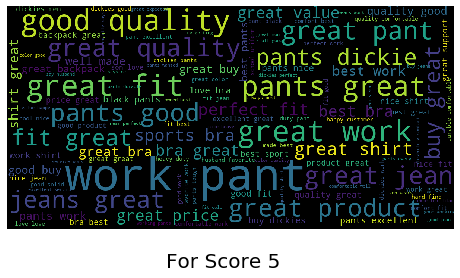

In [153]:
show_wordcloud(correlation1["Summary_Clean"][4], title = "For Score 5")
